In [1]:
import sys

!{sys.executable} -m pip install transformers[torch] datasets evaluate torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 51.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.8 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset, Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModel, TrainingArguments, Trainer, BertConfig, AutoConfig, DataCollatorWithPadding
from transformers.modeling_outputs import TokenClassifierOutput
import numpy as np
import evaluate
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import torch
import torch.nn as nn



In [3]:
df = pd.read_csv('subtaskB_clean_dev_cased.csv')
df.head()

,comment_text,topic
0,"Siamo davanti ad una prova, e non solo di quoz...",Qanon
1,La storia dei 2 bimbi di Bergamo - vaccini: qu...,Covid
2,L'avete capito che non toglieranno il green pa...,Covid
3,Quindi la farsa dello spazio e della terra a ...,Terra Piatta
4,"In breve tempo, per accedere a Internet, sarà ...",Qanon


## Load Dataset with HF's load_dataset

In [4]:
dataset_hf=load_dataset("csv", data_files='subtaskB_clean_dev_cased.csv')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [5]:
dataset_hf.set_format('pandas')

dataset_hf=dataset_hf['train'][:] #per definire la parte di training
#in questo modo tutto il dataset è settato come training

In [6]:
dataset_hf

,comment_text,topic
0,"Siamo davanti ad una prova, e non solo di quoz...",Qanon
1,La storia dei 2 bimbi di Bergamo - vaccini: qu...,Covid
2,L'avete capito che non toglieranno il green pa...,Covid
3,Quindi la farsa dello spazio e della terra a ...,Terra Piatta
4,"In breve tempo, per accedere a Internet, sarà ...",Qanon
...,...,...
805,"Incredibile!!!! EMA, Agenzia Europea del Farma...",Covid
806,Non ci saranno colloqui di pace con la Russia ...,Russia
807,"L'atmosfera è uno ""scudo protettivo"" che avvol...",Terra Piatta
808,OTTIMA NOTIZIA! Due ragioni per cui le élite n...,Covid


In [7]:
dataset_hf=Dataset.from_pandas(dataset_hf)

In [8]:
dataset_hf

Dataset({
    features: ['comment_text', 'topic'],
    num_rows: 810
})

In [ ]:
#dataset_hf = dataset_hf.rename_column("topic", "labels")

In [9]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
encoded_labels = le.fit_transform(dataset_hf['topic'])

In [10]:
dataset_hf = dataset_hf.add_column("labels", encoded_labels)

In [11]:
dataset_hf = dataset_hf.remove_columns('topic')

In [12]:
from datasets import ClassLabel

class_names = ['Covid', 'Qanon', 'Russia', 'Terra Piatta']
label = ClassLabel(num_classes=4, names=class_names)

dataset_hf = dataset_hf.cast_column("labels", label)

Casting the dataset:   0%|          | 0/810 [00:00<?, ? examples/s]

In [13]:
# Train Test Valid Split
train_testvalid = dataset_hf.train_test_split(test_size=0.09,seed=15, stratify_by_column='labels')

In [14]:
# test_valid = train_testvalid['test'].train_test_split(test_size=0.09,seed=15, stratify_by_column='labels')


dataset_hf = DatasetDict({
    'train': train_testvalid['train'],
    'test': train_testvalid['test'], #val2
    })

dataset_hf

DatasetDict({
    train: Dataset({
        features: ['comment_text', 'labels'],
        num_rows: 737
    })
    test: Dataset({
        features: ['comment_text', 'labels'],
        num_rows: 73
    })
})

In [32]:
# y_val = list(dataset_hf['val']['labels'])
y_test = list(dataset_hf['test']['labels'])

## cella da modificare

In [15]:
nome = 'bert-ita'
checkpoint = 'dbmdz/bert-base-italian-cased'

In [16]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

#tokenizer.model_max_len=512

## Vector size "distilbert-base-uncased"

In the model distilbert-base-uncased, each token is embedded into a vector of size 768. The shape of the output from the base model is

### (batch_size, max_sequence_length, embedding_vector_size=768)

In [17]:
def tokenize_fn(examples):
    return tokenizer(examples["comment_text"], padding="max_length", truncation=True)

tokenized_dataset = dataset_hf.map(tokenize_fn, batched=True)
tokenized_dataset

Map:   0%|          | 0/737 [00:00<?, ? examples/s]

Map:   0%|          | 0/73 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['comment_text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 737
    })
    test: Dataset({
        features: ['comment_text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 73
    })
})

In [18]:
tokenized_dataset.set_format('torch', columns=["input_ids", "attention_mask", "labels"] ) #cambia il formato per combinare con pytorch

data_collator = DataCollatorWithPadding(tokenizer=tokenizer) #forma i batch



## classe per LSTM

In [19]:
from transformers import AdamW
from torch.optim import Adagrad

class MyTaskSpecificCustomModelLSTM(nn.Module):
    def __init__(self, checkpoint, num_labels, lstm_hidden_size, optim, learning_rate, dropout):
        super(MyTaskSpecificCustomModelLSTM, self).__init__()
        self.num_labels = num_labels

        config = AutoConfig.from_pretrained(checkpoint, output_hidden_states=True, dropout=dropout)

        if optim == 'adamw_hf':
            self.model = AutoModel.from_pretrained(checkpoint, config=config)
            self.optimizer = AdamW(self.model.parameters(), lr=learning_rate)
        elif optim == 'adagrad':
            self.model = AutoModel.from_pretrained(checkpoint, config=config)
            self.optimizer = Adagrad(self.model.parameters(), lr=learning_rate)

        self.dropouts = nn.Dropout(0.1)

        input_size = self.model.config.hidden_size

        lstm_num_layers = 1

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=lstm_hidden_size,
                            num_layers=lstm_num_layers, dropout=0.1,batch_first=True)

        self.classifier = nn.Linear(lstm_hidden_size, num_labels)

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs[0]
        sequence_outputs = self.dropouts(last_hidden_state)

        lstm_output, _ = self.lstm(sequence_outputs)

        # Extract the hidden state of the last time step from the LSTM
        lstm_last_hidden_state = lstm_output[:, -1, :]

        logits = self.classifier(lstm_last_hidden_state)

        loss = None
        if labels is not None:
            loss_func = nn.CrossEntropyLoss()
            loss = loss_func(logits.view(-1, self.num_labels), labels.view(-1))

        return TokenClassifierOutput(loss=loss, logits=logits, hidden_states=outputs.hidden_states, attentions=outputs.attentions)

# Create PyTorch DataLoader

In [20]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['comment_text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 737
    })
    test: Dataset({
        features: ['comment_text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 73
    })
})

In [21]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    tokenized_dataset['train'], shuffle = True, batch_size = 8, collate_fn = data_collator
)

eval_dataloader = DataLoader(
     tokenized_dataset['test'], shuffle = True, collate_fn = data_collator
 )

## cella da modificare

In [22]:
dropout = 0.05
learning_rate = 5e-5
lr_lstm = 5e-5
optim='adamw_hf'
lstm_hidden_size = 256
num_epoch = 3

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #tipico codice torch per definire su cosa runnare
#mlp_hidden_sizes=[32, 16, 8]

model_task_specific = MyTaskSpecificCustomModelLSTM(checkpoint=checkpoint,
                                                    num_labels=4, lstm_hidden_size = lstm_hidden_size, optim=optim,
                                                    learning_rate = learning_rate, dropout=dropout  )\
                                                    .to(device)
#.to() trasferisce il modello al device

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [24]:
from transformers import get_scheduler

optimizer = AdamW(model_task_specific.parameters(), lr = lr_lstm )
# passo parametri e lr a optimizer

num_epoch = num_epoch

num_training_steps = num_epoch * len(train_dataloader)

lr_scheduler = get_scheduler(
    'linear',
    optimizer = optimizer,
    num_warmup_steps = 0, #dont need
    num_training_steps = num_training_steps,

)

In [25]:
from datasets import load_metric
metric = load_metric("f1")

<ipython-input-25-e4b2221a8929>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("f1")


# Training

In [26]:
from tqdm.auto import tqdm

In [27]:
# no best model
progress_bar_train = tqdm(range(num_training_steps))
progress_bar_eval = tqdm(range(num_epoch * len(eval_dataloader) ))

train_losses = []
val_losses = []

# train
for epoch in range(num_epoch):
    model_task_specific.train()
    train_epoch_loss = 0.0  # Inizializza la loss di addestramento per l'epoca corrente
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model_task_specific(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar_train.update(1)

        train_epoch_loss += loss.item()  # Aggiungi la loss di addestramento all'accumulatore

    train_losses.append(train_epoch_loss / len(train_dataloader))

# eval
    model_task_specific.eval()
    val_epoch_loss = 0.0  # Inizializza la loss di validazione per l'epoca corrente
    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad(): # da usare in val e test
            outputs = model_task_specific(**batch)

        val_loss = outputs.loss
        val_epoch_loss += val_loss.item()  # Aggiungi la loss di validazione all'accumulatore

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        metric.add_batch(predictions=predictions, references=batch['labels'])
        progress_bar_eval.update(1)

    val_losses.append(val_epoch_loss / len(eval_dataloader))  # Aggiungi la loss media di validazione alla lista

    print(metric.compute(average='macro')) # per ogni batch

  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'f1': 0.778657616892911}
{'f1': 0.8358542691876025}
{'f1': 0.8483016983016982}


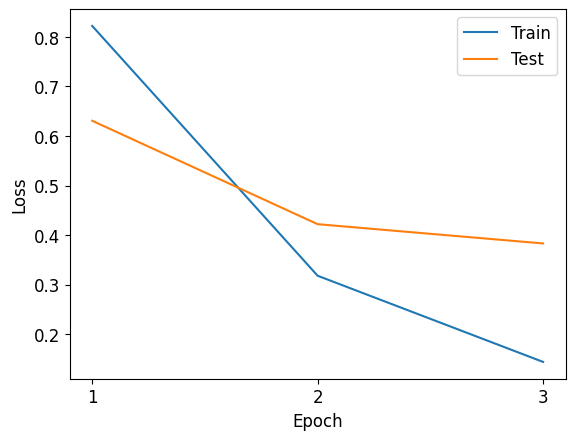

In [28]:
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 12})
plt.plot(range(1, num_epoch + 1), train_losses, label='Train')
plt.plot(range(1, num_epoch + 1), val_losses, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.xticks(range(1, num_epoch + 1))
plt.savefig(f'loss_curves_con_test_loss.pdf', dpi=300, bbox_inches='tight')
plt.show()

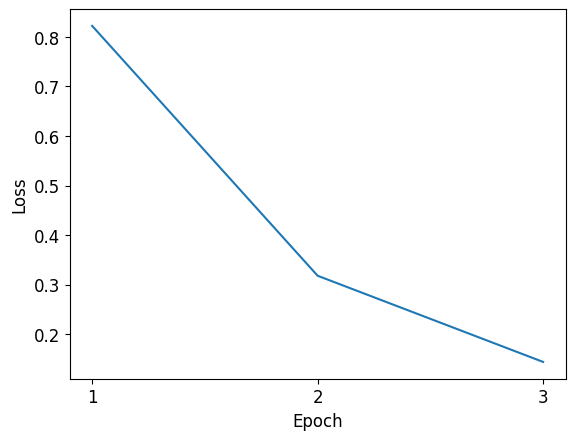

In [29]:
plt.rcParams.update({'font.size': 12})
plt.plot(range(1, num_epoch + 1), train_losses, label='Train')
#plt.plot(range(1, num_epoch + 1), val_losses, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.legend()
plt.xticks(range(1, num_epoch + 1))
plt.savefig(f'loss_curves_senza_test_loss.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [30]:
model_task_specific.eval()

test_dataloader = DataLoader(
    tokenized_dataset['test'], batch_size = 8, collate_fn = data_collator
)

y_pred_val = []
for batch in test_dataloader:
    batch = { k: v.to(device) for k, v in batch.items() }
    with torch.no_grad():
        outputs = model_task_specific(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim = -1)
    y_pred_val.extend(predictions.tolist())
    metric.add_batch(predictions = predictions, references=batch['labels'] )

metric.compute(average='macro')

{'f1': 0.8483016983016982}

In [33]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred_val)
print(report)

              precision    recall  f1-score   support

           0       0.92      0.92      0.92        39
           1       0.85      0.77      0.81        22
           2       0.67      0.80      0.73         5
           3       0.88      1.00      0.93         7

    accuracy                           0.88        73
   macro avg       0.83      0.87      0.85        73
weighted avg       0.88      0.88      0.88        73



In [48]:
print(nome, optim, learning_rate, dropout)

bert-ita adamw_hf 5e-05 0.05


In [34]:
with open(f"class_report_{nome}_{optim}_{learning_rate}_{dropout}_val1.html", "w") as file:
    file.write(report)

In [35]:
class_nAmes = ['Covid', 'QAnon', 'Russia', 'Terra Piatta']

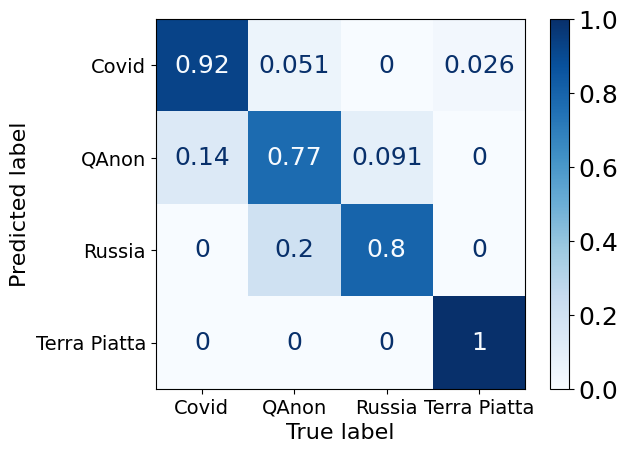

In [36]:
from sklearn.metrics import ConfusionMatrixDisplay

plt.rcParams.update({'font.size': 18})
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_val, cmap='Blues', normalize='true', display_labels=class_nAmes)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('True label', fontsize=16)
plt.ylabel('Predicted label', fontsize=16)
plt.savefig(f'class_report.pdf', dpi=300, bbox_inches='tight')
plt.show()

## errori

In [37]:
#df_val = dataset_hf['val'].to_pandas()
df_test = dataset_hf['test'].to_pandas()

In [38]:
def error_analyze(df, y_true, y_pred):
  id2label = {
    0: 'Covid',
    1: 'QAnon',
    2: 'Russia',
    3: 'Terra Piatta'
    }

  df_comments = pd.DataFrame()

  df_errors = df.copy()
  errors = dict()

  for idx, value in enumerate(y_true):
    if value != y_pred[idx]:
      errors[idx] = (value, y_pred[idx])
      df_comments.loc[idx, 'comment_text'] = df['comment_text'][idx]
      df_comments.loc[idx, 'Actual'] = id2label[value]
      df_comments.loc[idx, 'pred'] = id2label[ y_pred[idx] ]


      print(df['comment_text'][idx], '\nActual:', id2label[value], '\nPredicted:' ,id2label[y_pred[idx]])
      print('Vuoi commentare? ')
      commento = input()
      df_comments.loc[idx, 'comment'] = commento


      print()

  error_idx = list(errors.keys())
  df_errors = df.loc[error_idx].copy().reset_index(drop=True)


  return df_errors, df_comments


In [ ]:
def error_analyze(df, y_true, y_pred):
  df_errors = df.copy()
  errors = dict()

  for idx, value in enumerate(y_true):
    if value != y_pred[idx]:
      errors[idx] = (value, y_pred[idx])

  error_idx = list(errors.keys())
  df_errors = df.loc[error_idx].copy().reset_index(drop=True)

  return df_errors

In [39]:
#df_errors_val = error_analyze(df_val, y_val, y_pred_val)
df_errors_test = error_analyze(df_test, y_test, y_pred_val)

i covidioti dopo l'inculata della dittatura    AVANTI TUTTA FINCHÉ LA DITTATURA NON SARÀ DISTRUTTA  CONDIVIDI  --------------- 
Actual: Covid 
Predicted: QAnon
Vuoi commentare? 
dittatura quindi qanon

Dall'intervista alla parlamentare Ucraina Kira Rudik, emerge la VERITA' sul conflitto con la Russia: STIAMO COMBATTENDO per il NUOVO ORDINE MONDIALE!!! Abbiamo combattuto Putin negli ultimi otto anni!!!. L'Ucraina centro dei loschi traffici delle élite globaliste!!! 
Actual: QAnon 
Predicted: Russia
Vuoi commentare? 
erano entrambi, comunque più russiaa

Lesempio del Prof. Orsini è emblematico per come nel sistema autoritario, di fatto instaurato, la libera espressione del proprio pensiero - se non si trova allineato al regime - porta al tentativo di annien  del dissidente a 360 gradi    PERCHÉ IL MAINSTREAM SI STA ACCANENDO TANTO CONTRO ALESSANDRO ORSINI? 
Actual: Russia 
Predicted: QAnon
Vuoi commentare? 
sitema autoritario, libertà --> qanon

CI SCRIVONO 3 VESCOVI: Bergoglio promuove 